In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import binom
%matplotlib inline

In [2]:
# prices
price_Lc = 300
price_Hc = 350
price_Lf = 425
price_Hf = 500

# demand probabilities
#      [No Sale, Sale]
prob_Lc = [0.35,0.65]
prob_Hc = [0.7,0.3]
prob_Lf = [0.92,0.08]
prob_Hf = [0.96,0.04]

delta = 1/(1+(0.15/365)) # discount rate (DAILY)

n_coach = 100 # number of coach seats on plane
n_first = 20 # number of first class seats on plane
T = 365 # days until takeoff

over_allowed = 5
showprob_C = 0.95
showprob_F = 0.97

# cost of bump up/off
cost_bumpup = 50
cost_bumpoff = 425

sValues_C = np.arange(n_coach+1) # all possible number of seats left in coach
sValues_F = np.arange(n_first+1) # all possible number of seats left in first class
tValues = np.arange(T+1) # all possible days until takeoff

sN_C = len(sValues_C) # count possible state values in coach
sN_F = len(sValues_F) # count possible state values in first class
tN = len(tValues)

# Part 1

......

What is the expected discounted profit of selling these tickets and paying out overbooking costs over the course of the year?

a. On the day the flight takes off there is no revenue, only costs. You can calculate the expected cost using the binomial distribution (scipy.stats.binom.pmf), where the number of trials is the number of tickets sold, and a success is if a passenger shows up for the flight.

In [3]:
V = np.zeros((sN_C,sN_F,tN)) # initialize value function
U = np.zeros((sN_C,sN_F,tN)) # initialize optimal choice variable
# I'll also initialize two more U arrays - to store values for coach & first-class separately (JUST IN CASE)
U_C = np.zeros((sN_C,sN_F,tN))
U_F = np.zeros((sN_C,sN_F,tN))

# boundary/terminal condition
# last column
#V[:,:,tN-1] = 0 # when the flight takes off you can't make any more money
U[:,:,tN-1] = 0 # 0 is the value for no tickets for sale
U_C[:,:,tN-1] = 0
U_F[:,:,tN-1] = 0

In [4]:
########## TEST ##########
# scipy.stats.binom.pmf(115,120,0.95)*scipy.stats.binom.pmf(19,19,0.97)

In [5]:
# write a function
def overbook_func(n_ob): # n_ob: number of tickets overbooked in coach
  tot_n_coach = n_coach + n_ob # number of coach seats on plane
  tot_n_first = n_first # number of first class seats on plane
  T = 365 # days until takeoff

  sValues_C = np.arange(tot_n_coach + 1) # all possible number of seats left in coach
  sValues_F = np.arange(tot_n_first + 1) # all possible number of seats left in first class
  tValues = np.arange(T + 1) # all possible days until takeoff

  sN_C = len(sValues_C) # count possible state values in coach
  sN_F = len(sValues_F) # count possible state values in first class
  tN = len(tValues)

  V = np.zeros((sN_C,sN_F,tN)) # initialize value function
  U = np.zeros((sN_C,sN_F,tN)) # initialize optimal choice variable

  # boundary/terminal condition
  # last column
  #V[:,:,tN-1] = 0
  U[:,:,tN-1] = 0 # 0 is the value for no tickets for sale



  ##### Terminal condition #####
  for c in range(sN_C):  # coach sold
    for f in range(sN_F):  # first-class sold
      #coach_sold = sN_C - ncoach
      #first_sold = sN_F - nfirst
      exp_cost = 0

      # loop: 0 to all coach sold passengers show up & 0 to first class sold show up
      for i in range(c+1): # coach people show up
        for j in range(f+1): # first-class people show up
          if i > n_coach:
            #prob = scipy.stats.binom.pmf(i,c,0.95) * scipy.stats.binom.pmf(j,f,0.97)
            #cost = 0

            prob = binom.pmf(i, c, showprob_C) * binom.pmf(j, f, showprob_F)
            overseat = max(i - n_coach,0)
            up = min(n_first - j, overseat)
            cost = (cost_bumpup*up + cost_bumpoff*(overseat-up))
            exp_cost = exp_cost + prob * cost

      # store the amount of cost in V array
      V[c, f , -1] = exp_cost * (-1)



    ##### Bellman Equations #####
  for t in reversed(range(tN-1)):
    for c in range(sN_C):  # c: coach sold
      for f in range(sN_F):  # f: first-class sold

        # if coach is sold out and first-class is also sold out
        if (c == tot_n_coach and f == tot_n_first):  # flight full: 0 seats left in both classes
          V[c,f,t] = delta*V[c, f, t+1] # we cannot make any more money on this day
                                                                # we can only count the discounted expected value of tomorrow
          U[c,f,t] = 0  # no tickets for sale
          
        # if coach is sold out but first-class still has seats left
        elif (c == tot_n_coach and f != tot_n_first):  # 0 seats left only in coach

          ### FORMULA: prob_sold * price + delta * (prob_sold * value_tmr + prob_notsold * value_tmr) ###
          # low first-class price + discounted expected value of tomorrow
          val_LcLf = prob_Lf[1]*price_Lf + delta*(prob_Lf[1]*V[c,f+1,t+1] + prob_Lf[0]*V[c,f,t+1])
          val_HcLf = prob_Lf[1]*price_Lf + delta*(prob_Lf[1]*V[c,f+1,t+1] + prob_Lf[0]*V[c,f,t+1])
          # high first-class price + discounted expected value of tomorrow
          val_LcHf = prob_Hf[1]*price_Hf + delta*(prob_Hf[1]*V[c,f+1,t+1] + prob_Hf[0]*V[c,f,t+1])
          val_HcHf = prob_Hf[1]*price_Hf + delta*(prob_Hf[1]*V[c,f+1,t+1] + prob_Hf[0]*V[c,f,t+1])
          

          V[c,f,t] = max(val_LcLf, val_HcLf, val_LcHf, val_HcHf)
          U[c,f,t] = np.argmax([val_LcLf, val_HcLf, val_LcHf, val_HcHf]) + 1

        # if coach still has seats left but first-class is sold out
        elif(c != tot_n_coach and f == tot_n_first):  # 0 seats left only in first-class
          # low coach price + discounted expected value of tomorrow
          val_LcLf = prob_Lc[1]*price_Lc + delta*(prob_Lc[1]*V[c+1,f,t+1] + prob_Lc[0]*V[c,f,t+1])
          val_LcHf = prob_Lc[1]*price_Lc + delta*(prob_Lc[1]*V[c+1,f,t+1] + prob_Lc[0]*V[c,f,t+1])
          # high coach price + discounted expected value of tomorrow
          val_HcLf = prob_Hc[1]*price_Hc + delta*(prob_Hc[1]*V[c+1,f,t+1] + prob_Hc[0]*V[c,f,t+1])
          val_HcHf = prob_Hc[1]*price_Hc + delta*(prob_Hc[1]*V[c+1,f,t+1] + prob_Hc[0]*V[c,f,t+1])

          V[c,f,t] = max(val_LcLf, val_HcLf, val_LcHf, val_HcHf)
          U[c,f,t] = np.argmax([val_LcLf, val_HcLf, val_LcHf, val_HcHf]) + 1

        # if both coach and first-class have seats left
        else:
          # low coach price/low first-class price + discounted expected value of tomorrow
          val_LcLf = prob_Lc[1]*prob_Lf[1]*(price_Lc+price_Lf) + prob_Lc[1]*prob_Lf[0]*(price_Lc) + \
                     prob_Lc[0]*prob_Lf[1]*(price_Lf) + delta*(prob_Lc[1]*prob_Lf[1]*V[c+1,f+1,t+1] + \
                                                               prob_Lc[1]*prob_Lf[0]*V[c+1,f,t+1] + \
                                                               prob_Lc[0]*prob_Lf[1]*V[c,f+1,t+1] + \
                                                               prob_Lc[0]*prob_Lf[0]*V[c,f,t+1])

          # high coach price/low first-class price + discounted expected value of tomorrow
          val_HcLf = prob_Hc[1]*prob_Lf[1]*(price_Hc+price_Lf) + prob_Hc[1]*prob_Lf[0]*(price_Hc) + \
                     prob_Hc[0]*prob_Lf[1]*(price_Lf) + delta*(prob_Hc[1]*prob_Lf[1]*V[c+1,f+1,t+1] + \
                                                               prob_Hc[1]*prob_Lf[0]*V[c+1,f,t+1] + \
                                                               prob_Hc[0]*prob_Lf[1]*V[c,f+1,t+1] + \
                                                               prob_Hc[0]*prob_Lf[0]*V[c,f,t+1])   
                        
          # low coach price/high first-class price + discounted expected value of tomorrow
          val_LcHf = prob_Lc[1]*prob_Hf[1]*(price_Lc+price_Hf) + prob_Lc[1]*prob_Hf[0]*(price_Lc) + \
                     prob_Lc[0]*prob_Hf[1]*(price_Hf) + delta*(prob_Lc[1]*prob_Hf[1]*V[c+1,f+1,t+1] + \
                                                               prob_Lc[1]*prob_Hf[0]*V[c+1,f,t+1] + \
                                                               prob_Lc[0]*prob_Hf[1]*V[c,f+1,t+1] + \
                                                               prob_Lc[0]*prob_Hf[0]*V[c,f,t+1])
                     
          # high coach price/high first-class price + discounted expected value of tomorrow
          val_HcHf = prob_Hc[1]*prob_Hf[1]*(price_Hc+price_Hf) + prob_Hc[1]*prob_Hf[0]*(price_Hc) + \
                     prob_Hc[0]*prob_Hf[1]*(price_Hf) + delta*(prob_Hc[1]*prob_Hf[1]*V[c+1,f+1,t+1] + \
                                                               prob_Hc[1]*prob_Hf[0]*V[c+1,f,t+1] + \
                                                               prob_Hc[0]*prob_Hf[1]*V[c,f+1,t+1] + \
                                                               prob_Hc[0]*prob_Hf[0]*V[c,f,t+1])
                     

          V[c,f,t] = max(val_LcLf, val_HcLf, val_LcHf, val_HcHf)
          U[c,f,t] = np.argmax([val_LcLf, val_HcLf, val_LcHf, val_HcHf]) + 1
  

  return (V, U)





In [6]:
# when allow overbook 5 tickets 
  # - store U and V in "result" variable:
over_allowed_5 = 5
over_5_result = overbook_func(over_allowed_5)
over_5_result

(array([[[ 4.22428622e+04,  4.22317716e+04,  4.22203967e+04, ...,
           4.57905929e+02,  2.29000000e+02,  0.00000000e+00],
         [ 4.19078313e+04,  4.18969986e+04,  4.18858871e+04, ...,
           4.57905929e+02,  2.29000000e+02,  0.00000000e+00],
         [ 4.15679363e+04,  4.15572955e+04,  4.15463794e+04, ...,
           4.57905929e+02,  2.29000000e+02,  0.00000000e+00],
         ...,
         [ 3.48582799e+04,  3.48509970e+04,  3.48434526e+04, ...,
           4.57905929e+02,  2.29000000e+02,  0.00000000e+00],
         [ 3.43681978e+04,  3.43609149e+04,  3.43533706e+04, ...,
           4.55187046e+02,  2.29000000e+02,  0.00000000e+00],
         [ 3.38730792e+04,  3.38657963e+04,  3.38582520e+04, ...,
           3.89919896e+02,  1.95000000e+02,  0.00000000e+00]],
 
        [[ 4.19625949e+04,  4.19523565e+04,  4.19418440e+04, ...,
           4.57905929e+02,  2.29000000e+02,  0.00000000e+00],
         [ 4.16275603e+04,  4.16175797e+04,  4.16073305e+04, ...,
           4.57905929

In [7]:
# expected profit in this case...
V_5 = over_5_result[0]
U_5 = over_5_result[1]

expected_profit_5 = V_5[0,0,0]
print("When allow overbooking 5 tickets, expected profit is: $" + str(expected_profit_5))

When allow overbooking 5 tickets, expected profit is: $42242.86219879507


# Part 2

Repeat step (1) while allowing coach to be oversold by 6, 7, 8, ..., 15 seats. Which overbooking policy from this leads to the largest profits by the airline?

In [134]:
overbook_num1 = [6,7,8,9,10,11,12,13,14,15]  # store the number of tickets that is allowed to be overbooked
exp_profit_list1 = []  # store the expected profit

for n in range(6,16):
  print("Overbooking tickets: ", n)
  over_result = overbook_func(n)
  V_result = over_result[0]
  exp_profit = V_result[0,0,0]
  print("Expected Profit: $" + str(exp_profit))
  exp_profit_list1.append(exp_profit)



Overbooking tickets:  6
Expected Profit: $42368.86899301223
Overbooking tickets:  7
Expected Profit: $42444.241213317226
Overbooking tickets:  8
Expected Profit: $42482.211237591255
Overbooking tickets:  9
Expected Profit: $42496.112304378694
Overbooking tickets:  10
Expected Profit: $42495.97195739831
Overbooking tickets:  11
Expected Profit: $42488.25953578203
Overbooking tickets:  12
Expected Profit: $42476.99620870186
Overbooking tickets:  13
Expected Profit: $42464.59794015476
Overbooking tickets:  14
Expected Profit: $42452.36220993062
Overbooking tickets:  15
Expected Profit: $42440.944844238955


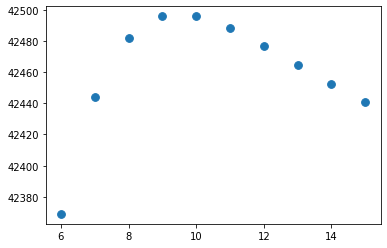

In [135]:
plt.scatter(overbook_num1,exp_profit_list1,marker='o', s=60)

In [136]:
print("Overbooking 9 seats leads to the largest profits, which is $42496.11")

Overbooking 9 seats leads to the largest profits, which is $42496.11


In [137]:
# Next, get the V and U vectors when overbook number = 9:

# when allow overbook 9 tickets 
  # - store U and V in "result" variable:
over_allowed_9 = 9
over_9_result = overbook_func(over_allowed_9)

# expected profit in this case...
V_9 = over_9_result[0]
U_9 = over_9_result[1]

expected_profit_9 = V_9[0,0,0]
print(expected_profit_9)
#print("When allow overbooking 5 tickets, expected profit is: $" + str(expected_profit))

42496.112304378694


# Part 3

Compare the previous policy, where there is a hard cap on seats sold, to another strategy where there is a third choice on each day when you’re deciding ticket prices. Consider a new policy that allows the airline to choose to sell no coach tickets on a day if it wants; the airline has the option to force demand to 0 on a day. Now there are 3 choices each day for coach: high price, low price, and no sale. There are still just 2 choices each day for first class: high and low price. Assume that the airline will never sell more than 120 seats in coach, but on any one day they can choose to not sell coach tickets. This way they can stop over-selling tickets not just based on how many they have sold, but also on how many days are left to sell. Does this policy have a better or worse expected profit than the best policy from step 2?

In [138]:
# some variables defined earlier...
# prices
price_Lc = 300
price_Hc = 350
price_Lf = 425
price_Hf = 500

# demand probabilities
#      [No Sale, Sale]
prob_Lc = [0.35,0.65]
prob_Hc = [0.7,0.3]
prob_Lf = [0.92,0.08]
prob_Hf = [0.96,0.04]

delta = 1/(1+(0.15/365)) # discount rate (DAILY)

In [139]:
# a new function
def new_overbook_func(n_ob): # n_ob: number of tickets overbooked in coach
  tot_n_coach = n_coach + n_ob # number of coach seats on plane
  tot_n_first = n_first # number of first class seats on plane
  T = 365 # days until takeoff

  sValues_C = np.arange(tot_n_coach + 1) # all possible number of seats left in coach
  sValues_F = np.arange(tot_n_first + 1) # all possible number of seats left in first class
  tValues = np.arange(T + 1) # all possible days until takeoff

  sN_C = len(sValues_C) # count possible state values in coach
  sN_F = len(sValues_F) # count possible state values in first class
  tN = len(tValues)

  V = np.zeros((sN_C,sN_F,tN)) # initialize value function
  U = np.zeros((sN_C,sN_F,tN)) # initialize optimal choice variable

  # boundary/terminal condition
  # last column
  #V[:,:,tN-1] = 0
  U[:,:,tN-1] = 0 # 0 is the value for no tickets for sale



  ##### Terminal condition #####
  for c in range(sN_C):  # coach sold
    for f in range(sN_F):  # first-class sold
      #coach_sold = sN_C - ncoach
      #first_sold = sN_F - nfirst
      exp_cost = 0

      # loop: 0 to all coach sold passengers show up & 0 to first class sold show up
      for i in range(c+1): # coach people show up
        for j in range(f+1): # first-class people show up
          if i > n_coach:
            #prob = scipy.stats.binom.pmf(i,c,0.95) * scipy.stats.binom.pmf(j,f,0.97)
            #cost = 0

            prob = binom.pmf(i, c, showprob_C) * binom.pmf(j, f, showprob_F)
            overseat = max(i - n_coach,0)
            up = min(n_first - j, overseat)
            cost = (cost_bumpup*up + cost_bumpoff*(overseat-up))
            exp_cost = exp_cost + prob * cost

      # store the amount of cost in V array
      V[c, f , -1] = exp_cost * (-1)



    ##### Bellman Equations #####
  for t in reversed(range(tN-1)):
    for c in range(sN_C):  # c: coach sold
      for f in range(sN_F):  # f: first-class sold

        # if coach is sold out and first-class is also sold out
        if (c == tot_n_coach and f == tot_n_first):  # flight full: 0 seats left in both classes
          V[c,f,t] = delta*V[c, f, t+1] # we cannot make any more money on this day
                                                                # we can only count the discounted expected value of tomorrow
          U[c,f,t] = 0  # no tickets for sale
          
        # if coach is sold out but first-class still has seats left
        elif (c == tot_n_coach and f != tot_n_first):  # 0 seats left only in coach

          ### FORMULA: prob_sold * price + delta * (prob_sold * value_tmr + prob_notsold * value_tmr) ###
          # low first-class price + discounted expected value of tomorrow
          val_LcLf = prob_Lf[1]*price_Lf + delta*(prob_Lf[1]*V[c,f+1,t+1] + prob_Lf[0]*V[c,f,t+1])
          val_HcLf = prob_Lf[1]*price_Lf + delta*(prob_Lf[1]*V[c,f+1,t+1] + prob_Lf[0]*V[c,f,t+1])
          # high first-class price + discounted expected value of tomorrow
          val_LcHf = prob_Hf[1]*price_Hf + delta*(prob_Hf[1]*V[c,f+1,t+1] + prob_Hf[0]*V[c,f,t+1])
          val_HcHf = prob_Hf[1]*price_Hf + delta*(prob_Hf[1]*V[c,f+1,t+1] + prob_Hf[0]*V[c,f,t+1])
          

          V[c,f,t] = max(val_LcLf, val_HcLf, val_LcHf, val_HcHf)
          U[c,f,t] = np.argmax([val_LcLf, val_HcLf, val_LcHf, val_HcHf]) + 1

        # if coach still has seats left but first-class is sold out
        elif(c != tot_n_coach and f == tot_n_first):  # 0 seats left only in first-class
          # low coach price + discounted expected value of tomorrow
          val_LcLf = prob_Lc[1]*price_Lc + delta*(prob_Lc[1]*V[c+1,f,t+1] + prob_Lc[0]*V[c,f,t+1])
          val_LcHf = prob_Lc[1]*price_Lc + delta*(prob_Lc[1]*V[c+1,f,t+1] + prob_Lc[0]*V[c,f,t+1])
          # high coach price + discounted expected value of tomorrow
          val_HcLf = prob_Hc[1]*price_Hc + delta*(prob_Hc[1]*V[c+1,f,t+1] + prob_Hc[0]*V[c,f,t+1])
          val_HcHf = prob_Hc[1]*price_Hc + delta*(prob_Hc[1]*V[c+1,f,t+1] + prob_Hc[0]*V[c,f,t+1])

          V[c,f,t] = max(val_LcLf, val_HcLf, val_LcHf, val_HcHf)
          U[c,f,t] = np.argmax([val_LcLf, val_HcLf, val_LcHf, val_HcHf]) + 1

        # if both coach and first-class have seats left
        else:
          # low coach price/low first-class price + discounted expected value of tomorrow
          val_LcLf = prob_Lc[1]*prob_Lf[1]*(price_Lc+price_Lf) + prob_Lc[1]*prob_Lf[0]*(price_Lc) + \
                     prob_Lc[0]*prob_Lf[1]*(price_Lf) + delta*(prob_Lc[1]*prob_Lf[1]*V[c+1,f+1,t+1] + \
                                                               prob_Lc[1]*prob_Lf[0]*V[c+1,f,t+1] + \
                                                               prob_Lc[0]*prob_Lf[1]*V[c,f+1,t+1] + \
                                                               prob_Lc[0]*prob_Lf[0]*V[c,f,t+1])

          # high coach price/low first-class price + discounted expected value of tomorrow
          val_HcLf = prob_Hc[1]*prob_Lf[1]*(price_Hc+price_Lf) + prob_Hc[1]*prob_Lf[0]*(price_Hc) + \
                     prob_Hc[0]*prob_Lf[1]*(price_Lf) + delta*(prob_Hc[1]*prob_Lf[1]*V[c+1,f+1,t+1] + \
                                                               prob_Hc[1]*prob_Lf[0]*V[c+1,f,t+1] + \
                                                               prob_Hc[0]*prob_Lf[1]*V[c,f+1,t+1] + \
                                                               prob_Hc[0]*prob_Lf[0]*V[c,f,t+1])   
                        
          # low coach price/high first-class price + discounted expected value of tomorrow
          val_LcHf = prob_Lc[1]*prob_Hf[1]*(price_Lc+price_Hf) + prob_Lc[1]*prob_Hf[0]*(price_Lc) + \
                     prob_Lc[0]*prob_Hf[1]*(price_Hf) + delta*(prob_Lc[1]*prob_Hf[1]*V[c+1,f+1,t+1] + \
                                                               prob_Lc[1]*prob_Hf[0]*V[c+1,f,t+1] + \
                                                               prob_Lc[0]*prob_Hf[1]*V[c,f+1,t+1] + \
                                                               prob_Lc[0]*prob_Hf[0]*V[c,f,t+1])
                     
          # high coach price/high first-class price + discounted expected value of tomorrow
          val_HcHf = prob_Hc[1]*prob_Hf[1]*(price_Hc+price_Hf) + prob_Hc[1]*prob_Hf[0]*(price_Hc) + \
                     prob_Hc[0]*prob_Hf[1]*(price_Hf) + delta*(prob_Hc[1]*prob_Hf[1]*V[c+1,f+1,t+1] + \
                                                               prob_Hc[1]*prob_Hf[0]*V[c+1,f,t+1] + \
                                                               prob_Hc[0]*prob_Hf[1]*V[c,f+1,t+1] + \
                                                               prob_Hc[0]*prob_Hf[0]*V[c,f,t+1])
          
          # In this case, we have No Sale option in coach class:
          # No sale in coach/low first-class price + discounted expected value of tomorrow
          val_NcLf = prob_Lf[1]*price_Lf + delta*(prob_Lf[0]*V[c,f,t+1] + prob_Lf[1]*V[c,f+1,t+1])

          # No sale in coach/high first-class price + discounted expected value of tomorrow
          val_NcHf = prob_Hf[1]*price_Hf + delta*(prob_Hf[0]*V[c,f,t+1] + prob_Hf[1]*V[c,f+1,n+1])
                     
                     

          V[c,f,t] = max(val_LcLf, val_HcLf, val_LcHf, val_HcHf, val_NcLf, val_NcHf)
          U[c,f,t] = np.argmax([val_LcLf, val_HcLf, val_LcHf, val_HcHf, val_NcLf, val_NcHf]) + 1
  

  return (V, U)





In [140]:
# - store U and V in "over_20_result" variable:
over_allowed_20 = 20
over_20_result = new_overbook_func(over_allowed_20)
over_20_result

(array([[[44338.80154938, 44318.45364552, 44298.03015811, ...,
            457.90592907,   229.        ,     0.        ],
         [43991.27893358, 43971.25308107, 43951.152903  , ...,
            457.90592907,   229.        ,     0.        ],
         [43633.74631741, 43614.34620276, 43594.85294086, ...,
            457.90592907,   229.        ,     0.        ],
         ...,
         [34944.30498521, 34939.37981405, 34934.10974927, ...,
            457.90592907,   229.        ,     0.        ],
         [34454.20368275, 34449.2789346 , 34444.00929564, ...,
            455.18704642,   229.        ,     0.        ],
         [33959.08387044, 33954.15915014, 33948.88953928, ...,
            389.91989593,   195.        ,     0.        ]],
 
        [[44088.35023107, 44068.06585846, 44047.7059257 , ...,
            457.90592907,   229.        ,     0.        ],
         [43740.89085063, 43720.92926159, 43700.89352511, ...,
            457.90592907,   229.        ,     0.        ],
       

In [141]:
# expected profit in this case...
V_20 = over_20_result[0]
U_20 = over_20_result[1]

expected_profit_20 = V_20[0,0,0]
print("In this case, when allow overbooking 20 tickets, expected profit is: $" + str(expected_profit_20))

In this case, when allow overbooking 20 tickets, expected profit is: $44338.80154938388


In [142]:
overbook_num = []  # store the number of tickets that is allowed to be overbooked
exp_profit_list = []  # store the expected profit

for n in range(20):
  overbook_num.append(n+1)
  #print("Overbooking tickets: ", n+1)
  over_result = new_overbook_func(n+1)
  V_result = over_result[0]
  exp_profit = V_result[0,0,0]
  print("Overbooking tickets:", n+1, " Expected Profit: $" + str(exp_profit))
  exp_profit_list.append(exp_profit)



Overbooking tickets: 1  Expected Profit: $41290.63589277684
Overbooking tickets: 2  Expected Profit: $41572.57008156323
Overbooking tickets: 3  Expected Profit: $41834.892327233894
Overbooking tickets: 4  Expected Profit: $42062.739083100605
Overbooking tickets: 5  Expected Profit: $42242.86219879507
Overbooking tickets: 6  Expected Profit: $42376.60410740296
Overbooking tickets: 7  Expected Profit: $42487.58852281237
Overbooking tickets: 8  Expected Profit: $42568.98433441085
Overbooking tickets: 9  Expected Profit: $42638.03814696482
Overbooking tickets: 10  Expected Profit: $42713.5754576192
Overbooking tickets: 11  Expected Profit: $42808.111179716165
Overbooking tickets: 12  Expected Profit: $42925.35229364208
Overbooking tickets: 13  Expected Profit: $43063.54870642237
Overbooking tickets: 14  Expected Profit: $43218.63127368909
Overbooking tickets: 15  Expected Profit: $43386.84725286574
Overbooking tickets: 16  Expected Profit: $43564.773475099646
Overbooking tickets: 17  Expec

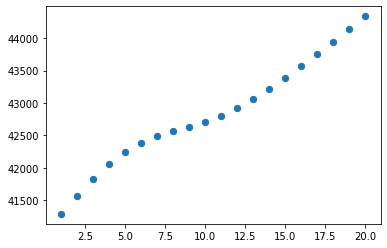

In [143]:
plt.scatter(overbook_num,exp_profit_list, marker='o', s=40)

# Part 4:

Now that you have solved the problem backwards, use the optimal overbooking policy to simulate the solution forward many times. How often is coach overbooked? How often are passengers kicked off the plane? What is the average overbooking cost? What is the volatility of discounted profits? Are there any other interesting questions you can think of? Make a few graphs to examine these questions. Do this for both policies above.

### First policy - allow overbooking 5 tickets
### We make 1000 simulations

In [144]:
print("From the first policy, the optimal overbooking policy we got is to allow 9 overbookings.")
print(" ")
print("So we use this overbooking number and its V and U arrays in this simulation part.")

From the first policy, the optimal overbooking policy we got is to allow 9 overbookings.
 
So we use this overbooking number and its V and U arrays in this simulation part.


In [145]:
simulation = 1000

# use the ob_num and U & V from the optimal overbooking policy so far
opti_ob_num = over_allowed_9
opti_V = V_9
opti_U = U_9


# define some vecs to store results of all simulations...
exp_profit_list = np.zeros(simulation)
total_revenue_list = np.zeros(simulation)
is_overbooked_list = np.zeros(simulation)
overbook_num_list = np.zeros(simulation)
kickoff_num_list = np.zeros(simulation)
has_kickoff_list = np.zeros(simulation)
bump_up_list = np.zeros(simulation)
overbook_cost_list = np.zeros(simulation)
c_sold_list = np.zeros(simulation)
f_sold_list = np.zeros(simulation)
total_sold_list = np.zeros(simulation)
passenger_showup_list = np.zeros(simulation)


##### --------START OF ALL SIMULATIONS-------- #####

for sim in range(simulation):
  tot_n_coach = n_coach + opti_ob_num # number of coach seats on plane
  tot_n_first = n_first # number of first class seats on plane
  T = 365 # days until takeoff

  sValues_C = np.arange(tot_n_coach + 1) # all possible number of seats left in coach
  sValues_F = np.arange(tot_n_first + 1) # all possible number of seats left in first class
  tValues = np.arange(T + 1) # all possible days until takeoff

  sN_C = len(sValues_C) # count possible state values in coach
  sN_F = len(sValues_F) # count possible state values in first class
  tN = len(tValues)

  V = np.zeros((sN_C,sN_F,tN)) # initialize value function
  U = np.zeros((sN_C,sN_F,tN)) # initialize optimal choice variable


  # define some vecs to store values in every single simulation...
  tot_revenue_vec = np.zeros(tN)
  c_sold_vec = np.zeros(tN-1)
  f_sold_vec = np.zeros(tN-1)
  price_vec = np.zeros(tN-1)

  # on the first day...
  profit = 0
  tot_revenue = 0
  overbook_cost = 0
  c = 0  # c: coach sold
  f = 0  # f: first-class sold
  ppl_kickoff = 0



  ##### --------START OF THIS ROUND OF SIMULATION-------- #####
  for t in range(tN-1):
    opt_price = opti_U[c,f,t]
    price_vec[t] = opt_price # store this price into the price vector

   # No sales, val_LcLf, val_HcLf, val_LcHf, val_HcHf, val_NcLf, val_NcHf
   #    0          1         2         3         4         5         6


    if opt_price == 1: # LcLF
      prob_c = prob_Lc[1]
      prob_f = prob_Lf[1]
      price_c = price_Lc
      price_f = price_Lf
    elif opt_price == 2: # HcLf
      prob_c = prob_Hc[1]
      prob_f = prob_Lf[1]
      price_c = price_Hc
      price_f = price_Lf
    elif opt_price == 3: # LcHf
      prob_c = prob_Lc[1]
      prob_f = prob_Hf[1]
      price_c = price_Lc
      price_f = price_Hf
    elif opt_price == 4: # HcHf
      prob_c = prob_Hc[1]
      prob_f = prob_Hf[1]
      price_c = price_Hc
      price_f = price_Hf
    elif opt_price == 5: # NcLf
      prob_c = 0
      prob_f = prob_Lf[1]
      price_c = 0
      price_f = price_Lf
    elif opt_price == 6: # NcHf
      prob_c = 0
      prob_f = prob_Hf[1]
      price_c = 0
      price_f = price_Hf
    else: # no tickets for sale
      prob_c = 0
      prob_f = 0
      price_c = 0
      price_f = 0

    if c == tot_n_coach - 1:
      prob_c = 0
    if f == tot_n_first - 1:
      prob_f = 0


    
    sale_c = (np.random.random(1) < prob_c) # simulate whether a sale of coach was made or not
    sale_f = (np.random.random(1) < prob_f) # simulate whether a sale of first-class was made or 


    # add the sale to number of tickets sold
    c = int(c + sale_c)
    f = int(f + sale_f)

    tot_revenue = tot_revenue + ((sale_c*price_c) + (sale_f*price_f)) * delta**(t-1) # add discounted revenue

    # save the results
    c_sold_vec[t] = c # seats sold (cumulative) in coach
    f_sold_vec[t] = f # seats sold (cumulative) in first-class
    tot_revenue_vec[t] = tot_revenue # revenue gained (until time t)

    ##### --------END OF THIS ROUNDS OF SIMULATION-------- #####

 

  # store the total number of booking in c and f in this round of simulation in the sold_lists:
  c_sold_list[sim] = c
  f_sold_list[sim] = f
  total_sold_list[sim] = c + f

  # store the total revenue in this round of simulation in the list
  total_revenue_list[sim] = tot_revenue
  # store overbook-or-not in this round of simulation in the list
  if c > n_coach:
    is_overbooked_list[sim] = 1


  # calculate the number of people who actually show up in this round of simulation
                             # (trails, probability, size)
  c_showup = int(np.random.binomial(c, showprob_C, 1))
  f_showup = int(np.random.binomial(f, showprob_F, 1))


  c_actual_showup = np.sum(c_showup)
  f_actual_showup = np.sum(f_showup)
  # store number of passengers who actually showed up in this round of simulation in passenger_showup_list
  passenger_showup_list[sim] = c_actual_showup + f_actual_showup

  # calculate the total bumpup & bumpoff cost in this round of simulation
  overseat = max(c_actual_showup - n_coach, 0)
  up = min(n_first - f_actual_showup, overseat)
  cost = (cost_bumpup*up + cost_bumpoff*(overseat-up))
  total_bump_cost = cost
  # store number of overbooking in this round of simulation in the overbook_num_list
  overbook_num_list[sim] = overseat
  # store number of bumped up passengers in this round of simulation in the bump_up_list
  bump_up_list[sim] = up
  # store total overbook cost in this round of simulation in the overbook_cost_list
  overbook_cost_list[sim] = total_bump_cost

  # store kick-off-or-not in the list of has_kickoff_list
  kickoff_num_list[sim] = max(overseat-up, 0)
  if (overseat-up > 0):
    has_kickoff_list[sim] = 1




In [146]:
print("The frequency that coach is overbooked is: " + str((np.sum(is_overbooked_list)/simulation)*100) + "%")

The frequency that coach is overbooked is: 100.0%


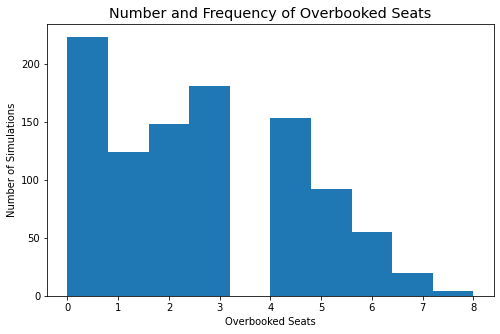

In [147]:
# Overbooking graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(overbook_num_list)
plt.title("Number and Frequency of Overbooked Seats",size='x-large')
plt.xlabel("Overbooked Seats")
plt.ylabel("Number of Simulations")
plt.show()

In [148]:
print("The frequency of passengers being kicked off the plane is: " + str((np.sum(has_kickoff_list)/simulation)*100) + "%")

The frequency of passengers being kicked off the plane is: 54.300000000000004%


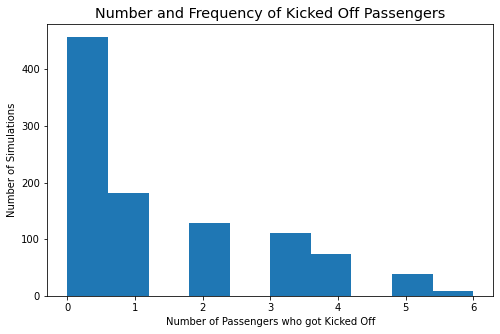

In [149]:
# Kickoff graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(kickoff_num_list)
plt.title("Number and Frequency of Kicked Off Passengers",size='x-large')
plt.xlabel("Number of Passengers who got Kicked Off")
plt.ylabel("Number of Simulations")
plt.show()

In [150]:
print("The average overbooking cost is: $" + str(np.mean(overbook_cost_list)))

The average overbooking cost is: $619.6


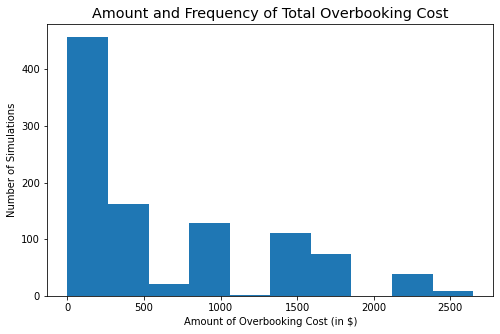

In [151]:
# Overbooking Cost graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(overbook_cost_list)
plt.title("Amount and Frequency of Total Overbooking Cost",size='x-large')
plt.xlabel("Amount of Overbooking Cost (in $)")
plt.ylabel("Number of Simulations")
plt.show()

In [152]:
print("The average discounted profits is: $" + str(np.mean(total_revenue_list)))
print("The variance of discounted profits is: $" + str(np.var(total_revenue_list)))
print("The standard deviation of discounted profits is: $" + str(np.std(total_revenue_list)))

The average discounted profits is: $42863.506494029294
The variance of discounted profits is: $561256.406966201
The standard deviation of discounted profits is: $749.1704792410076


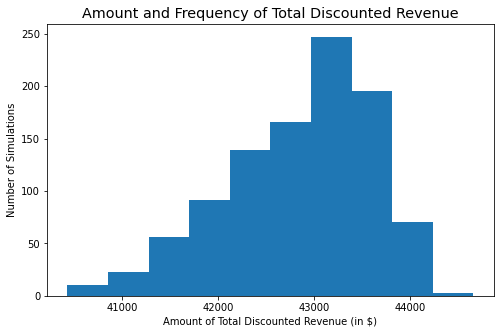

In [153]:
# Average Discounted Profit graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(total_revenue_list)
plt.title("Amount and Frequency of Total Discounted Revenue",size='x-large')
plt.xlabel("Amount of Total Discounted Revenue (in $)")
plt.ylabel("Number of Simulations")
plt.show()

### **Some other interesting questions we thought of:**

#### 1. How many passengers actually showed up in every simulation?
#### 2. How many passengers actually shoed up in every simulation?
#### 3. How many coach passengers got bumped up to first class in every simulation?

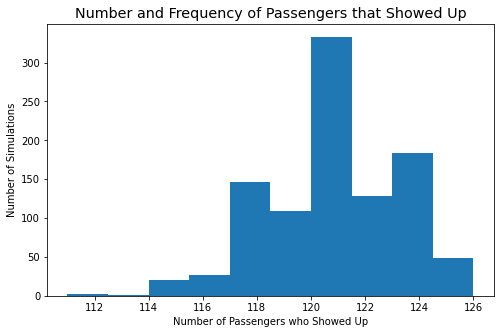

In [154]:
# Passengers show up graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(passenger_showup_list)
plt.title("Number and Frequency of Passengers that Showed Up",size='x-large')
plt.xlabel("Number of Passengers who Showed Up")
plt.ylabel("Number of Simulations")
plt.show()

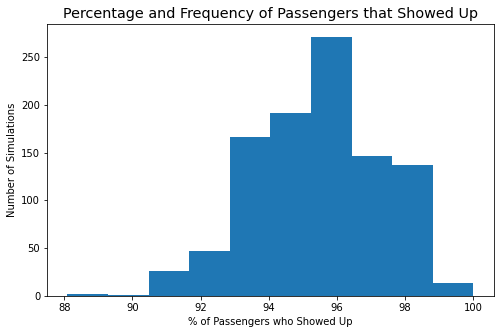

In [155]:
# Percentage of Passengers show up graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist((passenger_showup_list/total_sold_list)*100)
plt.title("Percentage and Frequency of Passengers that Showed Up",size='x-large')
plt.xlabel("% of Passengers who Showed Up")
plt.ylabel("Number of Simulations")
plt.show()

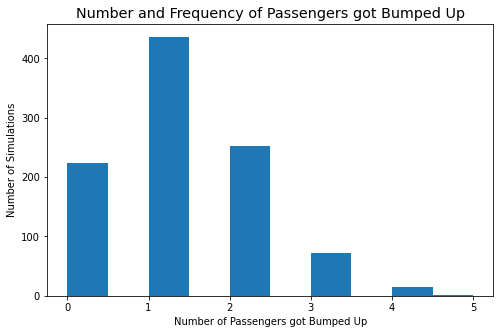

In [156]:
# Bump Up graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(bump_up_list)
plt.title("Number and Frequency of Passengers got Bumped Up",size='x-large')
plt.xlabel("Number of Passengers got Bumped Up")
plt.ylabel("Number of Simulations")
plt.show()

### Second policy - allow overbooking 20 tickets - We also make 1000 simulations

In [157]:
print("From the second policy, the optimal overbooking policy we got is to allow 20 overbookings.")
print(" ")
print("So we use this overbooking number and its V and U arrays in this simulation part.")

From the second policy, the optimal overbooking policy we got is to allow 20 overbookings.
 
So we use this overbooking number and its V and U arrays in this simulation part.


In [158]:
simulation = 1000

# use the ob_num and U & V from the optimal overbooking policy so far
opti_ob_num = 20
opti_V = V_20
opti_U = U_20


# define some vecs to store results of all simulations...
exp_profit_list = np.zeros(simulation)
total_revenue_list = np.zeros(simulation)
is_overbooked_list = np.zeros(simulation)
overbook_num_list = np.zeros(simulation)
kickoff_num_list = np.zeros(simulation)
has_kickoff_list = np.zeros(simulation)
bump_up_list = np.zeros(simulation)
overbook_cost_list = np.zeros(simulation)
c_sold_list = np.zeros(simulation)
f_sold_list = np.zeros(simulation)
total_sold_list = np.zeros(simulation)
passenger_showup_list = np.zeros(simulation)


##### --------START OF ALL SIMULATIONS-------- #####

for sim in range(simulation):
  #print(sim)
  tot_n_coach = n_coach + opti_ob_num # number of coach seats on plane
  tot_n_first = n_first # number of first class seats on plane
  T = 365 # days until takeoff

  sValues_C = np.arange(tot_n_coach + 1) # all possible number of seats left in coach
  sValues_F = np.arange(tot_n_first + 1) # all possible number of seats left in first class
  tValues = np.arange(T + 1) # all possible days until takeoff

  sN_C = len(sValues_C) # count possible state values in coach
  sN_F = len(sValues_F) # count possible state values in first class
  tN = len(tValues)

  V = np.zeros((sN_C,sN_F,tN)) # initialize value function
  U = np.zeros((sN_C,sN_F,tN)) # initialize optimal choice variable


  # define some vecs to store values in every single simulation...
  tot_revenue_vec = np.zeros(tN)
  c_sold_vec = np.zeros(tN-1)
  f_sold_vec = np.zeros(tN-1)
  price_vec = np.zeros(tN-1)

  # on the first day...
  profit = 0
  tot_revenue = 0
  overbook_cost = 0
  c = 0  # c: coach sold
  f = 0  # f: first-class sold
  ppl_kickoff = 0



  ##### --------START OF THIS ROUND OF SIMULATION-------- #####
  for t in range(tN-1):
    opt_price = opti_U[c,f,t]
    price_vec[t] = opt_price # store this price into the price vector

   # No sales, val_LcLf, val_HcLf, val_LcHf, val_HcHf, val_NcLf, val_NcHf
   #    0          1         2         3         4         5         6


    if opt_price == 1: # LcLF
      prob_c = prob_Lc[1]
      prob_f = prob_Lf[1]
      price_c = price_Lc
      price_f = price_Lf
    elif opt_price == 2: # HcLf
      prob_c = prob_Hc[1]
      prob_f = prob_Lf[1]
      price_c = price_Hc
      price_f = price_Lf
    elif opt_price == 3: # LcHf
      prob_c = prob_Lc[1]
      prob_f = prob_Hf[1]
      price_c = price_Lc
      price_f = price_Hf
    elif opt_price == 4: # HcHf
      prob_c = prob_Hc[1]
      prob_f = prob_Hf[1]
      price_c = price_Hc
      price_f = price_Hf
    elif opt_price == 5: # NcLf
      prob_c = 0
      prob_f = prob_Lf[1]
      price_c = 0
      price_f = price_Lf
    elif opt_price == 6: # NcHf
      prob_c = 0
      prob_f = prob_Hf[1]
      price_c = 0
      price_f = price_Hf
    else: # no tickets for sale
      prob_c = 0
      prob_f = 0
      price_c = 0
      price_f = 0

    if c == tot_n_coach - 1:
      prob_c = 0
    if f == tot_n_first - 1:
      prob_f = 0


    
    sale_c = (np.random.random(1) < prob_c) # simulate whether a sale of coach was made or not
    sale_f = (np.random.random(1) < prob_f) # simulate whether a sale of first-class was made or 


    # add the sale to number of tickets sold
    c = int(c + sale_c)
    f = int(f + sale_f)

    tot_revenue = tot_revenue + ((sale_c*price_c) + (sale_f*price_f)) * delta**(t-1) # add discounted revenue

    # save the results
    c_sold_vec[t] = c # seats sold (cumulative) in coach
    f_sold_vec[t] = f # seats sold (cumulative) in first-class
    tot_revenue_vec[t] = tot_revenue # revenue gained (until time t)

    ##### --------END OF THIS ROUNDS OF SIMULATION-------- #####

 

  # store the total number of booking in c and f in this round of simulation in the sold_lists:
  c_sold_list[sim] = c
  f_sold_list[sim] = f
  total_sold_list[sim] = c + f

  # store the total revenue in this round of simulation in the list
  total_revenue_list[sim] = tot_revenue
  # store overbook-or-not in this round of simulation in the list
  if c > n_coach:
    is_overbooked_list[sim] = 1


  # calculate the number of people who actually show up in this round of simulation
                             # (trails, probability, size)
  c_showup = int(np.random.binomial(c, showprob_C, 1))
  f_showup = int(np.random.binomial(f, showprob_F, 1))


  c_actual_showup = np.sum(c_showup)
  f_actual_showup = np.sum(f_showup)
  # store number of passengers who actually showed up in this round of simulation in passenger_showup_list
  passenger_showup_list[sim] = c_actual_showup + f_actual_showup

  # calculate the total bumpup & bumpoff cost in this round of simulation
  overseat = max(c_actual_showup - n_coach, 0)
  up = min(n_first - f_actual_showup, overseat)
  cost = (cost_bumpup*up + cost_bumpoff*(overseat-up))
  total_bump_cost = cost
  # store number of overbooking in this round of simulation in the overbook_num_list
  overbook_num_list[sim] = overseat
  # store number of bumped up passengers in this round of simulation in the bump_up_list
  bump_up_list[sim] = up
  # store total overbook cost in this round of simulation in the overbook_cost_list
  overbook_cost_list[sim] = total_bump_cost

  # store kick-off-or-not in the list of has_kickoff_list
  kickoff_num_list[sim] = max(overseat-up, 0)
  if (overseat-up > 0):
    has_kickoff_list[sim] = 1



In [159]:
print("The frequency that coach is overbooked is: " + str((np.sum(is_overbooked_list)/simulation)*100) + "%")

The frequency that coach is overbooked is: 100.0%


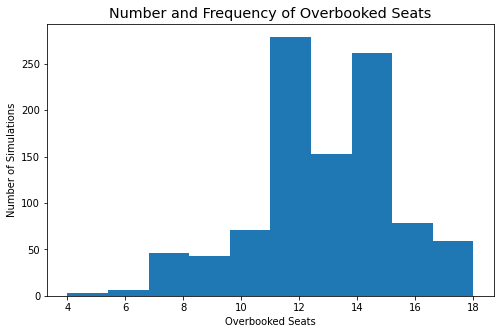

In [160]:
# Overbooking graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(overbook_num_list)
plt.title("Number and Frequency of Overbooked Seats",size='x-large')
plt.xlabel("Overbooked Seats")
plt.ylabel("Number of Simulations")
plt.show()

In [161]:
print("The frequency of passengers being kicked off the plane is: " + str((np.sum(has_kickoff_list)/simulation)*100) + "%")

The frequency of passengers being kicked off the plane is: 100.0%


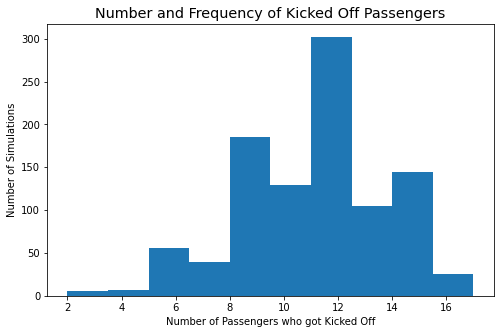

In [162]:
# Kickoff graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(kickoff_num_list)
plt.title("Number and Frequency of Kicked Off Passengers",size='x-large')
plt.xlabel("Number of Passengers who got Kicked Off")
plt.ylabel("Number of Simulations")
plt.show()

In [163]:
print("The average overbooking cost is: $" + str(np.mean(overbook_cost_list)))

The average overbooking cost is: $4709.875


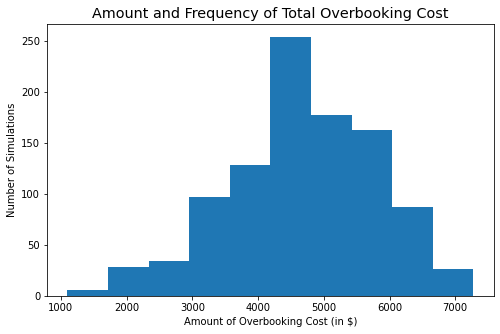

In [164]:
# Overbooking Cost graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(overbook_cost_list)
plt.title("Amount and Frequency of Total Overbooking Cost",size='x-large')
plt.xlabel("Amount of Overbooking Cost (in $)")
plt.ylabel("Number of Simulations")
plt.show()

In [165]:
print("The average discounted profits is: $" + str(np.mean(total_revenue_list)))
print("The variance of discounted profits is: $" + str(np.var(total_revenue_list)))
print("The standard deviation of discounted profits is: $" + str(np.std(total_revenue_list)))

The average discounted profits is: $44694.48941596324
The variance of discounted profits is: $433591.56162804086
The standard deviation of discounted profits is: $658.4766978626053


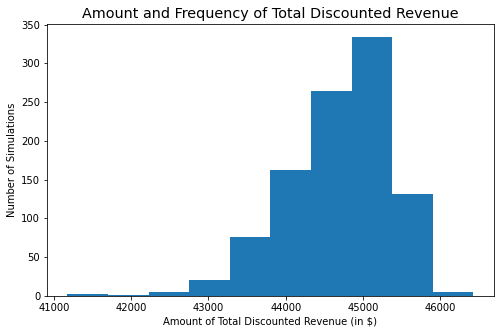

In [166]:
# Average Discounted Profit graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(total_revenue_list)
plt.title("Amount and Frequency of Total Discounted Revenue",size='x-large')
plt.xlabel("Amount of Total Discounted Revenue (in $)")
plt.ylabel("Number of Simulations")
plt.show()

### **Some other interesting questions we thought of:**

#### 1. How many passengers actually showed up in every simulation?
#### 2. How many passengers actually shoed up in every simulation?
#### 3. How many coach passengers got bumped up to first class in every simulation?

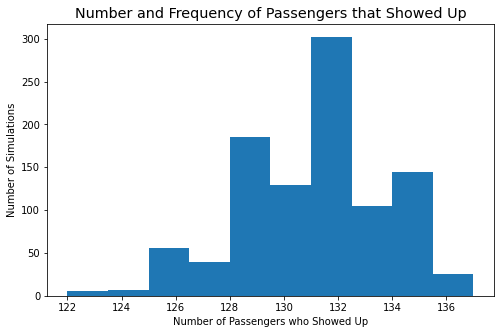

In [167]:
# Passengers show up graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(passenger_showup_list)
plt.title("Number and Frequency of Passengers that Showed Up",size='x-large')
plt.xlabel("Number of Passengers who Showed Up")
plt.ylabel("Number of Simulations")
plt.show()

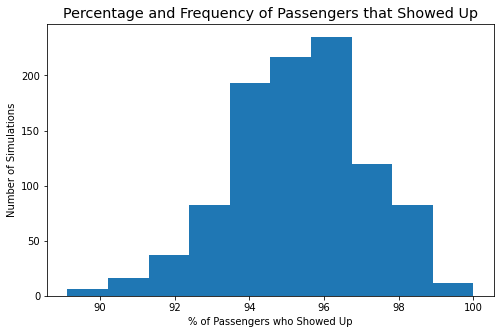

In [168]:
# Percentage of Passengers show up graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist((passenger_showup_list/total_sold_list)*100)
plt.title("Percentage and Frequency of Passengers that Showed Up",size='x-large')
plt.xlabel("% of Passengers who Showed Up")
plt.ylabel("Number of Simulations")
plt.show()

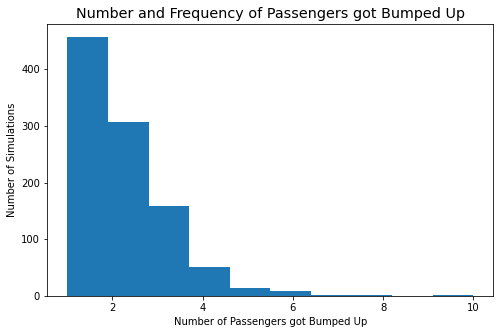

In [169]:
# Bump Up graph
plt.figure(figsize=(8,5),edgecolor='blue')
plt.hist(bump_up_list)
plt.title("Number and Frequency of Passengers got Bumped Up",size='x-large')
plt.xlabel("Number of Passengers got Bumped Up")
plt.ylabel("Number of Simulations")
plt.show()